# Inverse Solution of the Simple Image Polynomial Method Using Fixed-point Iteration Method

In [145]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.wcs import WCS

In [146]:
import cupy as cp

In Astronomy, we use [simple image polynomial convention](https://irsa.ipac.caltech.edu/data/SPITZER/docs/files/spitzer/shupeADASS.pdf) to perform coordinate transform, which transform (original) pixel coordinates $uv$ to corrected coordinates $UV$. The transform is defined as

\begin{equation}
\begin{pmatrix}
U \\
V
\end{pmatrix}
=
\begin{pmatrix}
u - f(u, v)\\
v - g(u, v)
\end{pmatrix}
\end{equation}

Here $uv$ are known coordinates. $f$ and $g$ are known functions, which are defined as Taylor series

\begin{equation}
f(u, v) = \sum_{p,q} A\_p\_q u^p v^q, \quad p+q \le \textrm{A_Order}
\end{equation}

and

\begin{equation}
g(u, v) = \sum_{p,q} B\_p\_q u^p v^q, \quad p+q \le \textrm{B_Order}
\end{equation}


Sometimes, we need to solve the the inverse probelm with known $UV$. We want to solve $uv$ has functions of $UV$.

One straightforward approach is to use Taylor expandsion and $\chi^2$ fitting. First, we express $u$ and $v$ as Taylor series of $U$ and $V$ with unknow coefficients. Second, we sample points from the $uv$ plane and compute the corresponding $U$ and $V$. Next, we use the computed $U$ $V$ and unknow coefficients to predict $u$ and $v$. Finally, we minimize the distance between the predicted $u$ $v$ and true $u$ $v$ to find the unknow expansion coefficients.

This method should work in principal but has many limitations in practice. First, we need to choose polynomial orders of $U$ and $V$, which may not be sufficint for convergence. Second, high order polynomials sampled from even grids suffer from degeneracy issue, which decerase its fitting ability.

To overcome these problems, we implement the [fixed-point iteration](https://en.wikipedia.org/wiki/Fixed-point_iteration) method. This method is adoped in astropy [\_all_world2pix](https://github.com/astropy/astropy/blob/main/astropy/wcs/wcs.py#L1692) method, which achieves better performance in terms of accuray. Our implementation leverages `cupy` and GPU to accelerate the computation, which is a bottleneck of the \_all_world2pix method.

The fixed-point iteration method takes the adavantage of a special class of functions called contractive mapping. The distance between two points $x1$ and $x2$ decreases after applying the contractive mapping $T$. Mathematically, this can be expressed as $|T(x1) - T(x2)| \lt |x1 - x2|$. Repeatedly applying contractive mapping to a given point will eventually converge to its fixed point $x^*$, where we have $x^*=T(x^*)$.

The solution of $uv$ can be expressed as fixed=point problem.

\begin{equation}
\begin{pmatrix}
u \\
v
\end{pmatrix}
=
\begin{pmatrix}
U - f(u, v)\\
V - g(u, v)
\end{pmatrix}
\end{equation}

We can pick initial guess $(u_0, v_0)$ and repeatedly apply $f$ and $g$ until the distance between $(u_n, v_n)$ and $(u_{n+1}, v_{n+1})$ is below our tolerance.

Condition of convergence:

Accorring to the mean value theorem, given a vector function $h$. $|h(x1) - h(x2)|\le | \nabla h(c) | |x1 - x2|$ with $\nabla h(c)$ as the Jacobian at c on the line segment between $x1$ and $x2$. (The 1D analogy is |h(x1) - h(x2)| = |h'(c)| |x1 - x2|) If the norm of the Jacobian $| \nabla h(c) |$ is smaller than 1, we have $|h(x1) - h(x2)|\lt |x1 - x2|$, which satisfies the requirement of contractive mapping. For the SIP algorithm, the coefficients A_Order and B_Order of $f$ and $g$ are at the scale between e-18 and 1e-9. Thus, the norm of the Jacobian matrix should be less than 1 in most cases.

In [153]:
def get_AB_from_header(header, A_order, B_order, verbose=True):
    """get A, B coefficients from fits header"""
    A = cp.zeros((A_order + 1, A_order + 1))
    B = cp.zeros((B_order + 1, B_order + 1))

    for i in range(0, A_order + 1):
        for j in range(0, A_order - i + 1):
            try:
                A[i,j] = header[f'A_{i}_{j}'] 
            except KeyError:
                if verbose:
                    print(f"Keyword 'A_{i}_{j}' not found, skipping...")
                continue

    for i in range(0, B_order + 1):
        for j in range(0, B_order - i + 1):
            try:
                B[i,j] = header[f'B_{i}_{j}']
            except KeyError:
                if verbose:
                    print(f"Keyword 'B_{i}_{j}' not found, skipping...")
                continue
    return A, B

def polynomial_sum(u, v, coef):
    """Evaluate the polynomial sum on GPU using CuPy."""
    order = coef.shape[0] - 1
    result = cp.zeros_like(u)
    
    for i in range(order + 1):
        for j in range(order - i + 1):
            result += coef[i, j] * (u**i) * (v**j)
    
    return result

def sample_grid(u_max, v_max, npoints_in_u_axis, npoints_in_v_axis):
    """Sample pixel points from a grid using CuPy."""
    u_coords = cp.linspace(1, u_max, npoints_in_u_axis)
    v_coords = cp.linspace(1, v_max, npoints_in_v_axis)
    # u_coords = cp.random.uniform(1, u_max, npoints_in_u_axis)
    # v_coords = cp.random.uniform(1, v_max, npoints_in_v_axis)
    u, v = cp.meshgrid(u_coords, v_coords)

    return u, v



def compute_uv_UV(width, height, A, B, AP_order, BP_order, npoints_in_u_axis, npoints_in_v_axis):
    """Compute u, v, U, V using CuPy."""
    u, v = sample_grid(width - 1, height - 1, npoints_in_u_axis, npoints_in_v_axis)
    f_uv = polynomial_sum(u, v, A)
    g_uv = polynomial_sum(u, v, B)

    U = u + f_uv
    V = v + g_uv

    return u, v, U, V

In [154]:
file_path = '/pscratch/sd/s/shl159/Roman/test_image/Roman_TDS_simple_model_J129_45219_14.fits'
with fits.open(file_path) as hdul:
    header = hdul[1].header
    image = hdul[1].data

In [212]:
A_order = header.get('A_ORDER')
B_order = header.get('B_ORDER')

AP_order = 4
BP_order = 4

width, height = image.shape

A, B = get_AB_from_header(header, A_order, B_order, verbose=False)

A = A
B = B

npoints_in_u_axis = 200
npoints_in_v_axis = 200

In [213]:
def corrected_to_original(U, V, A, B, tolerance=1e-8, max_iteration=10, check_convergence=True, verbose=True):

    u_pre, v_pre = U.copy(), V.copy()
    squared_tolerance = tolerance**2
    iteration_count = 1
    squared_distance = cp.ones_like(U) * cp.inf
    if check_convergence:
        squared_distance_pre = cp.ones_like(U) * cp.inf 

    while iteration_count <= max_iteration and cp.max(squared_distance) > squared_tolerance:
        f_uv = polynomial_sum(u_pre, v_pre, A)
        g_uv = polynomial_sum(u_pre, v_pre, B)
        u_next = U - f_uv
        v_next = V - g_uv
        squared_distance = (u_next - u_pre)**2 + (v_next - v_pre)**2

        # update for the next iteration
        iteration_count += 1
        u_pre = u_next.copy()
        v_pre = v_next.copy()
        if check_convergence:
            convergent_status = cp.any(squared_distance > squared_distance_pre)
            squared_distance_pre = squared_distance.copy()
    if verbose:
        print(f'iteration count: {iteration_count-1}')
        if check_convergence and convergent_status:
            print('[warning]: At least one of the input point fails to converge within the tolerance.')
    return u_pre, v_pre

In [218]:
%%time 

tolerance=1e-10
max_iteration=50

u, v, U, V = compute_uv_UV(width, height, A, B, AP_order, BP_order, npoints_in_u_axis, npoints_in_v_axis)
u_pred, v_pred = corrected_to_original(U, V, A, B, tolerance=tolerance, max_iteration=max_iteration, check_convergence=True, verbose=True)

iteration count: 3
CPU times: user 15.9 ms, sys: 0 ns, total: 15.9 ms
Wall time: 14.8 ms


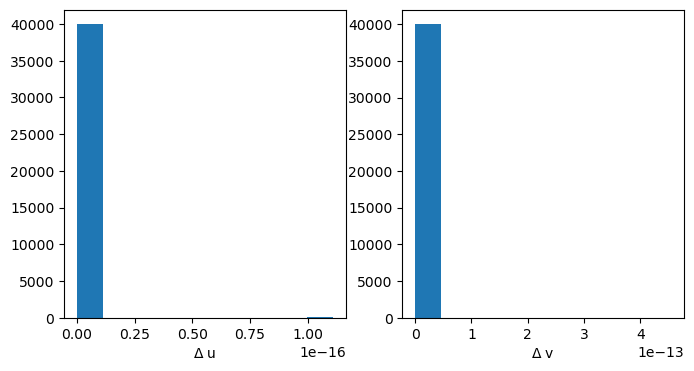

In [219]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist((u - u_pred).get().ravel())
axes[0].set_xlabel('$\Delta$ u')
axes[1].hist((v - v_pred).get().ravel())
axes[1].set_xlabel('$\Delta$ v');

Magnify A and B by 1000, result still converges

In [226]:
%%time 

tolerance=1e-10
max_iteration=50
u, v, U, V = compute_uv_UV(width, height, A*1000, B*1000, AP_order, BP_order, npoints_in_u_axis, npoints_in_v_axis)
u_pred, v_pred = corrected_to_original(U, V, A*1000, B*1000, tolerance=tolerance, max_iteration=max_iteration, check_convergence=True, verbose=True)

iteration count: 7
CPU times: user 28.7 ms, sys: 1.33 ms, total: 30 ms
Wall time: 28.8 ms


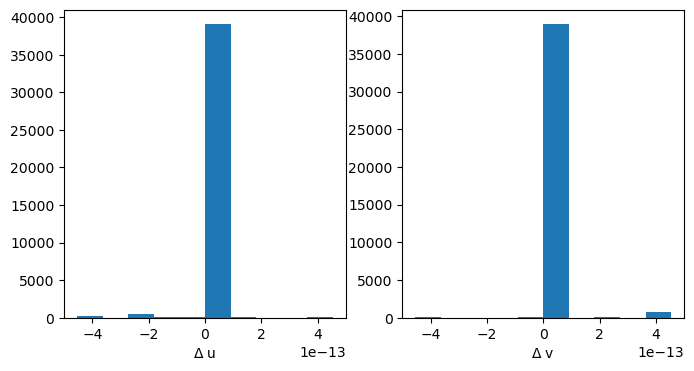

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist((u - u_pred).get().ravel())
axes[0].set_xlabel('$\Delta$ u')
axes[1].hist((v - v_pred).get().ravel())
axes[1].set_xlabel('$\Delta$ v');

## Adaptive approach

In [230]:

def corrected_to_original_adaptive(U, V, A, B, tolerance=1e-8, max_iteration=10, check_divergence=True, verbose=True):
    u_pre, v_pre = U.copy(), V.copy()
    u_next, v_next = U.copy(), V.copy()
    squared_tolerance = tolerance**2
    iteration_count = 1

    squared_distance = cp.ones_like(U) * cp.inf
    squared_distance_pre = cp.ones_like(U) * cp.inf
    # adaptive index
    adapt_idx = cp.ones_like(U).astype(bool)

    while iteration_count <= max_iteration and cp.max(squared_distance) > squared_tolerance:
        f_uv = polynomial_sum(u_pre[adapt_idx], v_pre[adapt_idx], A)
        g_uv = polynomial_sum(u_pre[adapt_idx], v_pre[adapt_idx], B)
        u_next[adapt_idx] = U[adapt_idx] - f_uv
        v_next[adapt_idx] = V[adapt_idx] - g_uv
        squared_distance[adapt_idx] = (u_next[adapt_idx] - u_pre[adapt_idx])**2 + (v_next[adapt_idx] - v_pre[adapt_idx])**2

        # update for the next iteration
        if check_divergence:
            divergent = squared_distance > squared_distance_pre

            out_of_tolerance = squared_distance > squared_tolerance
            adapt_idx = (~divergent) & out_of_tolerance
        else:
            adapt_idx = (squared_distance >= squared_tolerance).reshape(U.shape)

        iteration_count += 1
        u_pre = u_next.copy()
        v_pre = v_next.copy()
        squared_distance_pre = squared_distance.copy()

    if verbose:
        print(f'iteration count: {iteration_count-1}')
        if cp.any(adapt_idx):
            print('[warning]: At least one of the input point fails to converge within the tolerance')
    return u_pre, v_pre


In [232]:
%%time 


tolerance=1e-10
max_iteration=50
u, v, U, V = compute_uv_UV(width, height, A, B, AP_order, BP_order, npoints_in_u_axis, npoints_in_v_axis)
u_pred, v_pred = corrected_to_original_adaptive(U, V, A, B, tolerance=tolerance, max_iteration=max_iteration, check_divergence=True, verbose=True)

iteration count: 3
CPU times: user 20.4 ms, sys: 0 ns, total: 20.4 ms
Wall time: 19.3 ms


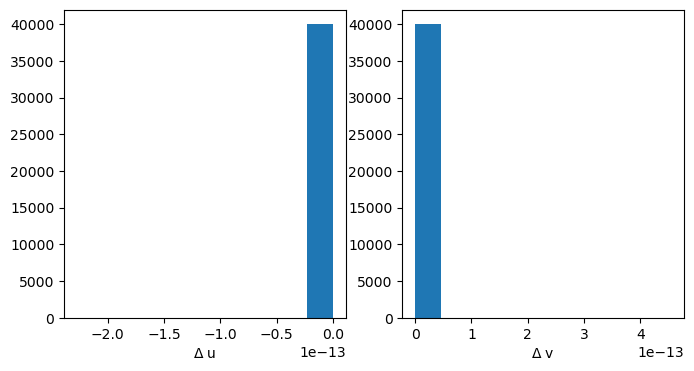

In [233]:

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist((u - u_pred).get().ravel())
axes[0].set_xlabel('$\Delta$ u')
axes[1].hist((v - v_pred).get().ravel())
axes[1].set_xlabel('$\Delta$ v');

In [234]:
%%time 


tolerance=1e-10
max_iteration=50
u, v, U, V = compute_uv_UV(width, height, A*1000, B*1000, AP_order, BP_order, npoints_in_u_axis, npoints_in_v_axis)
u_pred, v_pred = corrected_to_original_adaptive(U, V, A*1000, B*1000, tolerance=tolerance, max_iteration=max_iteration, check_divergence=True, verbose=True)

iteration count: 7
CPU times: user 39.5 ms, sys: 0 ns, total: 39.5 ms
Wall time: 38.4 ms


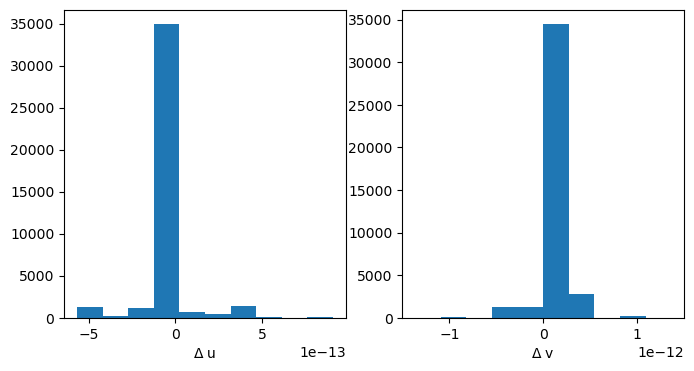

In [235]:

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist((u - u_pred).get().ravel())
axes[0].set_xlabel('$\Delta$ u')
axes[1].hist((v - v_pred).get().ravel())
axes[1].set_xlabel('$\Delta$ v');